### Imports

In [20]:
# import necessary libraries
import pandas as pd
import numpy as np
import os
import random
import glob
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.datatypes import check_is_mtype, convert

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, roc_curve, auc, make_scorer, confusion_matrix
from sklearn.utils import resample

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFE
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, train_test_split, cross_val_score
import optuna
import xgboost as xgb
import shap

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense, GlobalAveragePooling1D

In [21]:
# Seed value for the project.
seed_value = 42

In [22]:
# Outcome variables - as decided with the host organisation.
# These values correspond to a ventricular fibrillation.
OUTCOMES = [
'ATP in VT/VF delivered',
'ATP One Shot delivered',
'VT1 therapy episodes',
'VF episodes',
'ATP in VT zones started',
'ATP One Shot started',
'ATP in VT zones successful',
'ATP One Shot successful',
'Shocks started',
'Shocks aborted',
'Shocks successful']

# Feature variables specific to patients with single chamber ICDs (ventricular).
VENTR_FEATURES = ['RV pacing impedance [ohm]',
 'RV sensing amplitude (daily mean) [mV]',
 'RV sensing amplitude (daily min.) [mV]',
 'Daily shock lead impedance [ohm]',
 'Right ven. pacing (RVp) [%]',
 'VT1 monitoring episodes',
 'VT1 therapy episodes',
 'VT2 episodes',
 'VF episodes',
 'Episodes during temporary program',
 'ATP in VT zones started',
 'ATP in VT zones successful',
 'ATP One Shot started',
 'ATP One Shot successful',
 'Shocks started',
 'Shocks aborted',
 'Shocks successful',
 'Ineffective ven. max. energy shocks',
 'Mean ventricular heart rate [bpm]',
 'Mean ventricular heart rate at rest [bpm]',
 'Patient activity [% of day]',
 'ATP in VT/VF delivered',
 'ATP One Shot delivered']

In [23]:
# VENTR_FEATURES = [i for i in VENTR_FEATURES if i not in OUTCOMES+[ 'VT1 monitoring episodes', 'VT2 episodes', 'Episodes during temporary program', 'Ineffective ven. max. energy shocks']]

In [24]:
VENTR_FEATURES

['RV pacing impedance [ohm]',
 'RV sensing amplitude (daily mean) [mV]',
 'RV sensing amplitude (daily min.) [mV]',
 'Daily shock lead impedance [ohm]',
 'Right ven. pacing (RVp) [%]',
 'VT1 monitoring episodes',
 'VT1 therapy episodes',
 'VT2 episodes',
 'VF episodes',
 'Episodes during temporary program',
 'ATP in VT zones started',
 'ATP in VT zones successful',
 'ATP One Shot started',
 'ATP One Shot successful',
 'Shocks started',
 'Shocks aborted',
 'Shocks successful',
 'Ineffective ven. max. energy shocks',
 'Mean ventricular heart rate [bpm]',
 'Mean ventricular heart rate at rest [bpm]',
 'Patient activity [% of day]',
 'ATP in VT/VF delivered',
 'ATP One Shot delivered']

In [25]:
# # Generating cases and controls lists of patient IDs. 
# case_path = os.getcwd() + '/data/the_rest/the_full_data/Deidentified_data/Cases'
# contr_path = os.getcwd() + '/data/the_rest/the_full_data/Deidentified_data/Controls'
# case_files = glob.glob(os.path.join(case_path, "*.csv"))
# contr_files = glob.glob(os.path.join(contr_path, "*.csv"))

# cases = []
# controls = []

# # Creating a list of cases IDs.
# for f in case_files:
#     to_replace = case_path + '/'
#     case_id = f.replace(to_replace, '')
#     case_id = case_id.replace('.csv', '')
#     cases.append(int(case_id))

# # Creating a list of control IDs.
# for f in contr_files:
#     to_replace = contr_path + '/'
#     contr_id = f.replace(to_replace, '')
#     contr_id = contr_id.replace('.csv', '')
#     controls.append(int(contr_id))

# # Creating a list of all patient IDs.
# all_patients = cases + controls

# # Checking which patients were not included. 
# set(np.array(range(1,226))) - set(all_patients)

In [26]:
outcome_df = pd.read_csv(os.getcwd()+'/cleaned_df.csv')

### Functions
splitting function  
function to run the models

In [27]:
# Reshaper 2 returns a 2D df with patient_id and index in columns. 
class DataReshaper4(BaseEstimator, TransformerMixin):
    def __init__(self):
        '''
        Converts 3d np array into 2d np array.
        '''
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        num_samples, num_time_steps, num_features = X.shape
        reshaped = X.reshape(num_samples, num_time_steps * num_features)
        return reshaped

In [28]:
def split_xgb(df, window_size=30):
    """
    Splits the input DataFrame based on specified conditions for generating
    training data for the XGBoost model.

    Parameters:
    -----------
    df - pd.DataFrame
        The input DataFrame containing patient data.
    window_size - int
        The size of the window to extract data before the 'shock' event. 
        Default is 30.

    Returns:
    --------
    new_df - pd.DataFrame
        A new DataFrame containing the extracted input data.
    outcome - list
        A list of outcome labels (1 for ICD therapy, 0 for non-cases).
    """
    outcome = []
    new_df = pd.DataFrame()
    pt_id = df['patient_id'].unique()
    
    for n in pt_id:
        pt_data = df[df['patient_id'] == n]
        is_case = pt_data['case'].iloc[0] == 1

        if is_case:
            for i, row in pt_data.iterrows():
                if row['shock'] > 0 and row['index'] > window_size:
                    inp_df = df.loc[i - (window_size):i - 1].copy()
                    new_df = pd.concat([new_df, inp_df])
                    outcome.append(1)
                    break
        else:
            mid_index = len(pt_data) // 2
            inp_df = pt_data.iloc[mid_index - (window_size+1):mid_index - 1].copy()
            outcome.append(0)
            new_df = pd.concat([new_df, inp_df])


    return new_df, outcome

In [29]:
def running_one_sample_model(X_all_extr, y_all_extr, classifier, n_splits=5): 

    # Initialize your model (e.g., RandomForestClassifier)
    model = classifier

    # Lists to store evaluation metrics
    roc_auc_scores = []
    accuracy_scores = []
    predicted_proba = []
    observed = []
    sensitivity_scores = []
    specificity_scores = []
    
    # Converting data into days x features columns. 
    resh4 = DataReshaper4()
    xgb_2d = resh4.transform(X_all_extr)
    
    X = xgb_2d#xgb_dat.copy()
    y = y_all_extr#np.array(outcome)

    cross_validator = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform manual cross-validation
    for i, (train_idx, val_idx) in enumerate(cross_validator.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]


        # Fitting the model to acquire roc_auc, accuracy, sensitiv./specific.
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)
        y_pred_class = (y_pred_proba[:, 1] >= 0.5).astype(int)
        
        # Storing predicted probabilities and true values for this fold.
        predicted_proba.append(y_pred_proba[:, 1])
        observed.append(y_val)
        
        # Calculating accuracy and ROC-AUC for this fold, adding to lists.
        roc_extr = roc_auc_score(y_val, y_pred_proba[:, 1])
        accu_extr = accuracy_score(y_val, y_pred_class)
        
        # Storing ROC-AUC and accuracy for this fold
        roc_auc_scores.append(roc_extr)
        accuracy_scores.append(accu_extr)
        
        # Calculating the confusion matrix for this fold.
        conf_matrix = confusion_matrix(y_val, y_pred_class)
        
        # Calculating sensitivity and specificity for this fold.
        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Storing sensitivity and specificity for this fold.
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)

    if n_splits == 10:
        roc_low_conf = mean(roc_auc_scores) - 1.96*(np.std(roc_auc_scores))
        roc_up_conf = mean(roc_auc_scores) + 1.96*(np.std(roc_auc_scores))
        ac_low_conf = mean(accuracy_scores) - 1.96*(np.std(accuracy_scores))
        ac_up_conf = mean(accuracy_scores) + 1.96*(np.std(accuracy_scores))

        print(f"ROC-AUC 95% CI: {roc_low_conf.round(3)} - {roc_up_conf.round(3)}")
        print(f"Accuracy 95% CI: {ac_low_conf.round(3)} - {ac_up_conf.round(3)}")

    # Printing the metrics    
    print(f"Accuracy score: {np.mean(accuracy_scores).round(3)}")
    print(f"ROC-AUC score: {np.mean(roc_auc_scores).round(3)}")
    print(f"Sensitivity scores: {np.mean(sensitivity_scores).round(3)}")
    print(f"Specificity scores: {np.mean(specificity).round(3)}")

    return (predicted_proba, observed, roc_auc_scores, accuracy_scores, sensitivity_scores,
    specificity_scores)

### Wrangling the data

In [30]:
WINDOW_SIZE = 4


# Generating the input dataframe for XGBoost with pre-defined window size.
split_df, outcome = split_xgb(outcome_df.drop('level_0', axis=1).reset_index(), WINDOW_SIZE)
# Droping the outcome columns.
split_df = split_df.drop('case', axis=1)
split_df = split_df.drop('shock', axis=1)
split_df = split_df.drop('level_0', axis=1)

In [31]:
N_FEAT = len(split_df.columns) - 2 # subtracting patient_id and index.
N_PT = int(len(split_df)/WINDOW_SIZE)
xgb_dat = np.empty((N_PT, N_FEAT, WINDOW_SIZE))
pt_id = split_df['patient_id'].unique()
pt_count = 0
# Looping through patient IDs.
for n in pt_id:
    pt_count 
    pt_data = split_df[split_df['patient_id']==n].copy()

    # Looping through days in the window.
    for i in range(len(VENTR_FEATURES)):
        xgb_dat[pt_count, i, :] = np.array(pt_data[VENTR_FEATURES].iloc[:, i])
    pt_count += 1

### Running the XGBoost model

In [32]:
classifier = xgb.XGBClassifier()
(pred_y, true_y, roc_auc_scores, accuracy_scores, sensitivity_scores,
specificity_scores) = running_one_sample_model(xgb_dat, np.array(outcome),
classifier, n_splits=10)

ROC-AUC 95% CI: 0.455 - 0.918
Accuracy 95% CI: 0.693 - 0.939
Accuracy score: 0.816
ROC-AUC score: 0.687
Sensitivity scores: 0.225
Specificity scores: 0.882


#### Bootstrapping Test Predictions - CIs

In [33]:
n_bootstraps = 1000
bootstrapped_scores = []
pred_flat_y = np.concatenate(pred_y)
true_flat_y = np.concatenate(true_y)

rng = np.random.RandomState(seed_value)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(pred_flat_y), len(pred_flat_y))
    bootstrapped_true_y = true_flat_y[indices]  # Use indices for bootstrapped samples
    
    if len(np.unique(bootstrapped_true_y)) < 2:
        continue
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample

    bootstrapped_pred_y = pred_flat_y[indices]  # Use indices for bootstrapped samples
    score = roc_auc_score(bootstrapped_true_y, bootstrapped_pred_y)
    bootstrapped_scores.append(score)


sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.594 - 0.763]


#### Plotting ROC curve

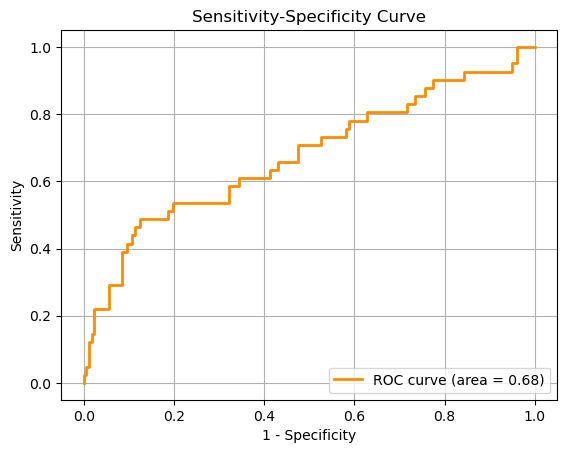

In [34]:
# Concatenate the observed and predicted_proba lists across all folds
observed_all = np.concatenate(true_y)
predicted_proba_all = np.concatenate(pred_y)

# Compute ROC curve and AUC for the combined data
fpr, tpr, _ = roc_curve(observed_all, predicted_proba_all)
roc_auc_cnn = auc(fpr, tpr)

# Calculate sensitivity and specificity from the ROC curve data
sensitivity = tpr
specificity = 1 - fpr

# Plot sensitivity-specificity curve
plt.figure()
plt.plot(1 - specificity, sensitivity, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cnn)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity-Specificity Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### Calculating best concurrent specificity and sensitivity

In [35]:
# Calculate Youden's J statistic for each threshold
youden_j_values = np.array(sensitivity) + np.array(specificity) - 1
thresholds = np.arange(0.0, 1.01, 0.01)

# Find the index of the threshold that maximizes Youden's J value
best_threshold_index = np.argmax(youden_j_values)

# Get the corresponding threshold and its sensitivity and specificity values
best_threshold = thresholds[best_threshold_index]
best_sensitivity = sensitivity[best_threshold_index]
best_specificity = specificity[best_threshold_index]

# Desired specificity level
desired_specificity = 0.9

# Find the index in the specificity array that is closest to the desired specificity
closest_index = np.argmin(np.abs(specificity - desired_specificity))

# Get the corresponding sensitivity value at the closest index
sensitivity_at_desired_specificity = sensitivity[closest_index]

print(f"Sensitivity at {desired_specificity}% Specificity:", sensitivity_at_desired_specificity)

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best Sensitivity: {best_sensitivity:.4f}")
print(f"Best Specificity: {best_specificity:.4f}")

# Best Threshold: 0.2800
# Best Sensitivity: 0.7791
# Best Specificity: 0.8333

Sensitivity at 0.9% Specificity: 0.3902439024390244
Best Threshold: 0.2100
Best Sensitivity: 0.4878
Best Specificity: 0.8757


## CNN

#### Building Pipeline

In [36]:
WINDOW_SIZE = 10
N_FEAT = outcome_df.shape[1]-6
n_splits = 10

In [37]:
class DataReshaper1(BaseEstimator, TransformerMixin):
    """
    A custom data transformation class that reshapes 3D data into a tabular
    format with both patient ID and time in the rows.

    It can be used as part of a data preprocessing pipeline to reshape 3D data
    into a tabular format.

    Methods:
    __init__(self): Constructor method, initializes the object.
    fit(self, X, y=None): Fit method, returns the object itself.
    transform(self, X): Transforms the input 3D data into a tabular DataFrame.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Transforms the input 3D data into a tabular DataFrame.

        Parameters:
        ----------
        X np.matrix
            The input 3D data with patient, day, and feature dimensions.

        Returns:
        --------
        df pd.DataFrame
            The tabular DataFrame with reshaped data.
        """
        # Calculate the number of features (columns) in the original DataFrame.
        n_feat = X.shape[2]

        # Create an empty list to store data rows.
        rows = []

        # Loop through each patient and each day in the window.
        for pt_count in range(X.shape[0]):
            for i in range(WINDOW_SIZE):
                # Get the data for the current day and patient.
                data_for_day = X[pt_count, i, :]
                pt_id = pt_count + 1  # Assuming patient_id starts from 1.

                # Create a dictionary to store the row data.
                row_data = {'patient_id': pt_id, 'index': i + 1}

                # Add the VENTR_FEATURES data to the dictionary.
                for j, feature in enumerate(VENTR_FEATURES):
                    row_data[feature] = data_for_day[j]

                # Append the row data to the list of rows.
                rows.append(row_data)

            # Create a pandas DataFrame from the list of rows.
            df = pd.DataFrame(rows)
        return df

In [38]:
# Utilising the min max scaler class for data normalisation. 
scaler = MinMaxScaler()

In [39]:
class DataReshaper2(BaseEstimator, TransformerMixin):
    def __init__(self):
        '''
        A custom data transformation class that reshapes data to a 3D numpy
        array for Convolutional Neural Networks (CNNs). 

        It can be used as part of a data preprocessing pipeline to reshape data
        for CNNs.

        Methods:
        __init__(self): Constructor method, initializes the object.
        fit(self, X, y=None): Fit method, returns the object itself.
        transform(self, X): Transforms the input data into a 3D numpy array.
        '''

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        '''
        Transforms the input data into a format suitable for CNNs. 
        Utilises previous data labels to create a 3D numpy array after scaling
        with MinMaxScaler().

        Parameters:
        ----------
        X pd.DataFrame
            The input data with scaled values.

        Returns:
        --------
        cnn_dat np.ndarray
            The transformed data in a format suitable for CNNs.'''

        column_names = ['patient_id']+['index']+VENTR_FEATURES
        scaled_df = pd.DataFrame(X, columns=column_names)

        n_feat = len(scaled_df.columns) - 2 # subtracting patient_id and index.
        n_pt = int(len(scaled_df)/WINDOW_SIZE)
        cnn_dat = np.empty((n_pt, WINDOW_SIZE, n_feat))

        pt_id = scaled_df['patient_id'].unique()
        pt_count = 0
        # Looping through patient IDs.
        for n in pt_id:
            pt_count 
            pt_data = scaled_df[scaled_df['patient_id']==n].copy()

            # Looping through days in the window.
            for i in range(WINDOW_SIZE):
                cnn_dat[pt_count, i, :] = np.array(pt_data[VENTR_FEATURES].iloc[i])
            pt_count += 1

        return cnn_dat

In [40]:
def create_binary_classifier_model_1(learning_rate=0.001):
    """
    Creates a binary classifier model using Convolutional Neural Networks (CNNs).

    This function creates a binary classifier model using TensorFlow and Keras.
    The model architecture consists of two Conv1D layers with ReLU activation,
    followed by a Flatten layer, two Dense layers with ReLU activation, and an
    output Dense layer with a sigmoid activation for binary classification.

    Parameters:
    ----------
    learning_rate float, optional
        The learning rate for the Adam optimizer. Default is 0.001.

    Returns:
    --------
    model tf.keras.Model
        The binary classifier model.
    """
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(WINDOW_SIZE, N_FEAT)),
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        Dropout(0,5),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0,5),
        Dense(1, activation='sigmoid')  # Output layer with one neuron and sigmoid activation
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Specify the learning rate for Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='accuracy')
    
    return model


In [41]:
# Create the pipeline
pipeline_1 = Pipeline([
    ('reshape1', DataReshaper1()),
    ('scaler', MinMaxScaler()),
    ('reshape2', DataReshaper2()),
    ('cnn', KerasClassifier(model=create_binary_classifier_model_1, epochs=20, batch_size=32, validation_split=0.2))      
])

#### 1D-CNN 1 Sample Per Patient

##### Wrangling the data for CNN

In [42]:
# Slitting the data utilising the splitting function (xgb).
split_df, outcome = split_xgb(outcome_df.drop('level_0', axis=1).reset_index(), WINDOW_SIZE)
# Dropping the outcome columns.
split_df = split_df.drop('case', axis=1)
split_df = split_df.drop('shock', axis=1)
split_df = split_df.drop('level_0', axis=1)

In [43]:
X_train = split_df.copy()
y_train = outcome

# Number of patients
N_PT = int(len(X_train)/WINDOW_SIZE)

# Creating an empty dataframe of correct dimensions (patients, days, predictors)
cnn_dat = np.empty((N_PT, WINDOW_SIZE, N_FEAT))
pt_id = X_train['patient_id'].unique()
pt_count = 0

# Iterating through patient IDs to access their data.
for n in pt_id:
    pt_count 
    pt_data = X_train[X_train['patient_id']==n].copy()

    # Iterating through days in the window and adding all feature values to the days.
    for i in range(WINDOW_SIZE):
        cnn_dat[pt_count, i, :] = np.array(pt_data[VENTR_FEATURES].iloc[i])
    pt_count += 1

X_train = cnn_dat

#### Pipeline Run

In [44]:
# Setting up stratified K-fold cross validation to return roc-auc scores
strat_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
roc_auc_scores = cross_val_score(pipeline_1, X_train, y_train, cv=strat_cv, scoring='roc_auc')

Epoch 1/20
5/5 [==============================] - 1s 51ms/step - loss: 0.6153 - accuracy: 0.6603 - val_loss: 0.3759 - val_accuracy: 0.9000
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.5293 - accuracy: 0.7885 - val_loss: 0.3053 - val_accuracy: 0.9000
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.5105 - accuracy: 0.7885 - val_loss: 0.3392 - val_accuracy: 0.9000
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.4862 - accuracy: 0.8013 - val_loss: 0.3653 - val_accuracy: 0.9250
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.4651 - accuracy: 0.8077 - val_loss: 0.3203 - val_accuracy: 0.9250
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.4415 - accuracy: 0.8077 - val_loss: 0.3426 - val_accuracy: 0.9250
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.4213 - accuracy: 0.8269 - val_loss: 0.3567 - val_accuracy: 0.9250
Epoch 8/20
5/5 [=================

In [45]:
roc_auc_scores.mean()

0.6180718954248366

#### Manual Run - CNN

In [51]:
n_splits = 8

# Setting up lists to hold outcome variables. 
observed = []
predicted_proba = []
roc_auc_scores = []
accuracy_scores = []

# Initialising cross-validator
cross_validator = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Input arrays.
X, y = cnn_dat, np.array(outcome)

# Perform manual cross-validation
for train_idx, val_idx in cross_validator.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # CNN model
    cnn_model = create_binary_classifier_model_1()

    # Running the pipeline steps:
    resh1 = DataReshaper1()
    X_train = resh1.transform(X_train)
    X_val = resh1.transform(X_val)

    minmax = MinMaxScaler()
    X_train = minmax.fit_transform(X_train)
    X_val = minmax.transform(X_val)

    resh2 = DataReshaper2()
    X_train = resh2.transform(X_train)
    X_val = resh2.transform(X_val)

    # Training the model on the training data
    cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    # Getting the predicted probabilities (scores) for positive class (class 1)
    y_pred_probs = cnn_model.predict(X_val)
    y_pred_class = (y_pred_probs >= 0.5).astype(int)

    # Calculating the ROC-AUC score and accuracy
    roc_auc = roc_auc_score(y_val, y_pred_probs)
    accu_extr = accuracy_score(np.array(y_val), y_pred_class)

    # Adding values to relevant lists
    roc_auc_scores.append(roc_auc)
    accuracy_scores.append(accu_extr)
    observed.append(y_val)
    predicted_proba.append(y_pred_probs)

# Calculating confidence intervals on 10-fold cross validation
if n_splits == 10:
    roc_low_conf = mean(roc_auc_scores) - 1.96*(np.std(roc_auc_scores))
    roc_up_conf = mean(roc_auc_scores) + 1.96*(np.std(roc_auc_scores))
    ac_low_conf = mean(accuracy_scores) - 1.96*(np.std(accuracy_scores))
    ac_up_conf = mean(accuracy_scores) + 1.96*(np.std(accuracy_scores))
    print(f"ROC-AUC 95% CI: {roc_low_conf.round(3)} - {roc_up_conf.round(3)}")
    print(f"Accuracy 95% CI: {ac_low_conf.round(3)} - {ac_up_conf.round(3)}")

print(f"ROC-AUC score: {np.mean(roc_auc_scores).round(3)}")
print(f"Accuracy score: {np.mean(accuracy_scores).round(3)}")

# Calculate average accuracy across all folds
np.array(roc_auc_scores).mean().round(3)

1/1 [==============================] - 0s 66ms/step
ROC-AUC score: 0.652
Accuracy score: 0.835


0.652